In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [2]:
import os
import numpy as np

import pandas as pd
import cudf as gd

from cuml.manifold.umap import UMAP as cumlUMAP

In [ ]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [21]:
DATASET_ID = 'european_starling_gentner_segmented'

In [3]:
all_windows = np.load('starling_umap_windows.npy')

In [5]:
cuml_umap = cumlUMAP(min_dist = 0.5)
embedding = cuml_umap.fit_transform(all_windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [6]:
np.shape(embedding)

(790672, 2)

In [16]:
np.min(embedding, axis=0)

array([-12299.36425781, -12105.04101562])

In [15]:
np.max(embedding, axis=0)

array([10039.3203125 ,  8720.89257812])

In [12]:
import matplotlib.pyplot as plt

(-20, 20)

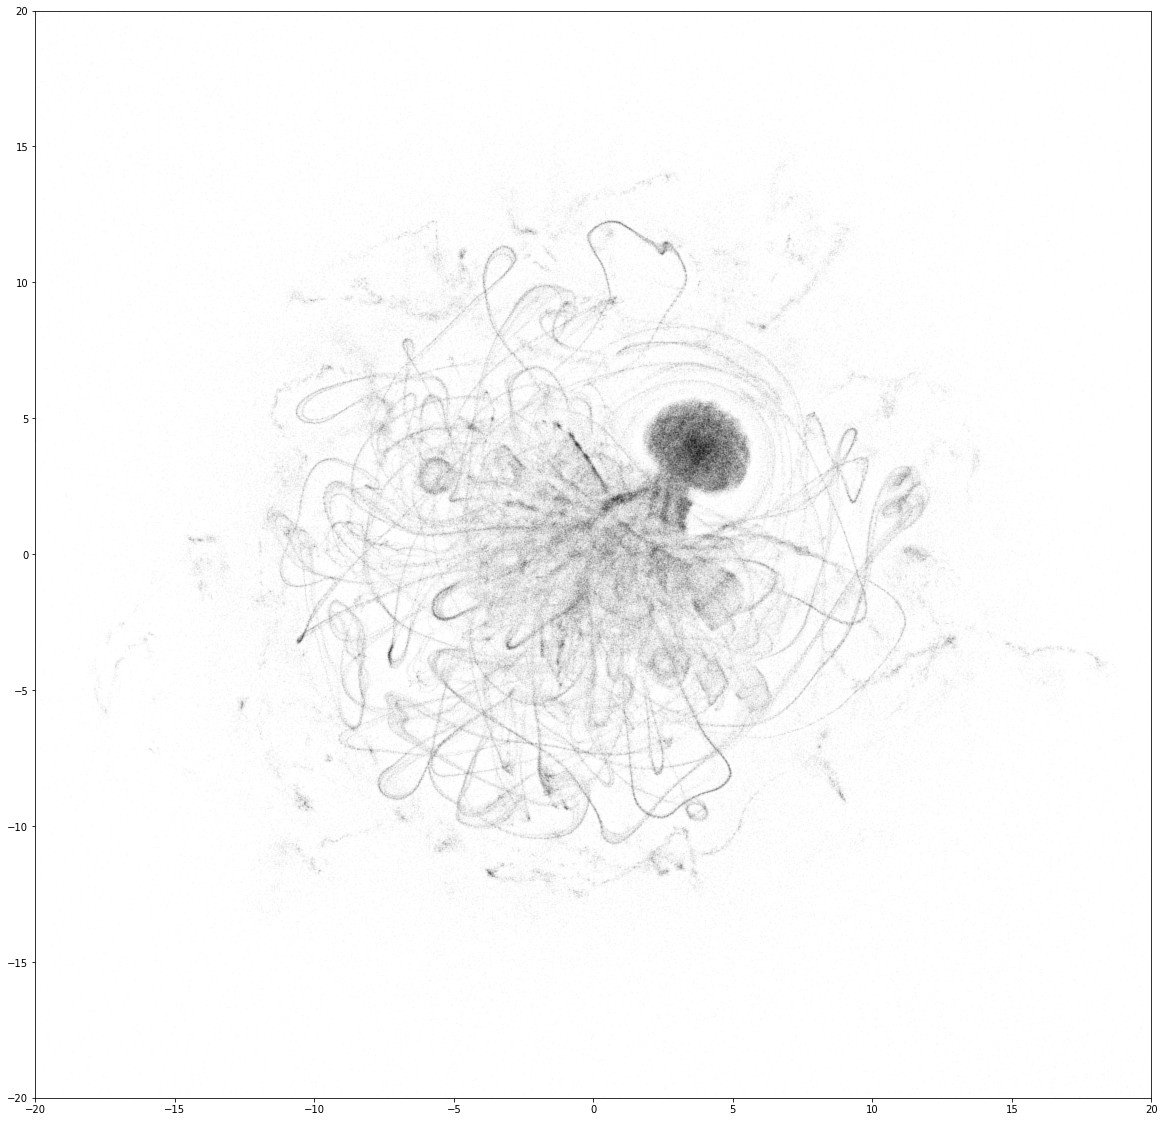

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.01, s = 1, color='k')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])

In [24]:
indv = 'b1053'
window_length_ms = 200

In [29]:
keys_loc = DATA_DIR /'umap_windows' / DATASET_ID / ('keya_starling_' + indv + '_' + str(window_length_ms) +'.npy')
keys  = np.load(keys_loc.as_posix())
keys[:3]

In [37]:
window_length_loc = DATA_DIR /'umap_windows' / DATASET_ID / ('window_lengths_starling_' + indv + '_' + str(window_length_ms) +'.npy')
window_lengths  = np.load(window_length_loc.as_posix())
window_lengths[:3]

array([15459, 15692,  6323])

In [31]:
syllable_df = pd.concat([pd.read_pickle(i) for i in list((DATA_DIR / 'indv_dfs' / DATASET_ID).glob('*.pickle'))])
syllable_df[:3]

start_time  end_time   indv  indvi                         key   rate  \
0       0.000     0.166  b1076      0  2017-08-10_11-00-01-000000  44100   
1       0.386     1.062  b1076      0  2017-08-10_11-00-01-000000  44100   
2       1.140     1.520  b1076      0  2017-08-10_11-00-01-000000  44100   

                                         spectrogram  syllables_sequence_id  \
0  [[5, 5, 5, 5, 5, 16, 3, 5, 5, 5, 5, 5, 5, 5, 5...                      0   
1  [[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,...                      0   
2  [[1, 1, 1, 3, 4, 3, 1, 2, 1, 2, 2, 2, 2, 1, 2,...                      0   

   syllables_sequence_pos                     umap  hdbscan_labels  
0                       0    [-2.419678, -4.66706]              -1  
1                       1  [-6.9649086, 7.8358817]              47  
2                       2  [-6.4222746, 1.2335316]              -1

In [32]:
hop_length_ms = 20

In [33]:
window_length_frames = int(window_length_ms / hop_length_ms)

In [34]:
z = embedding

In [41]:
import seaborn as sns
from tqdm.autonotebook import tqdm

(-20, 20)

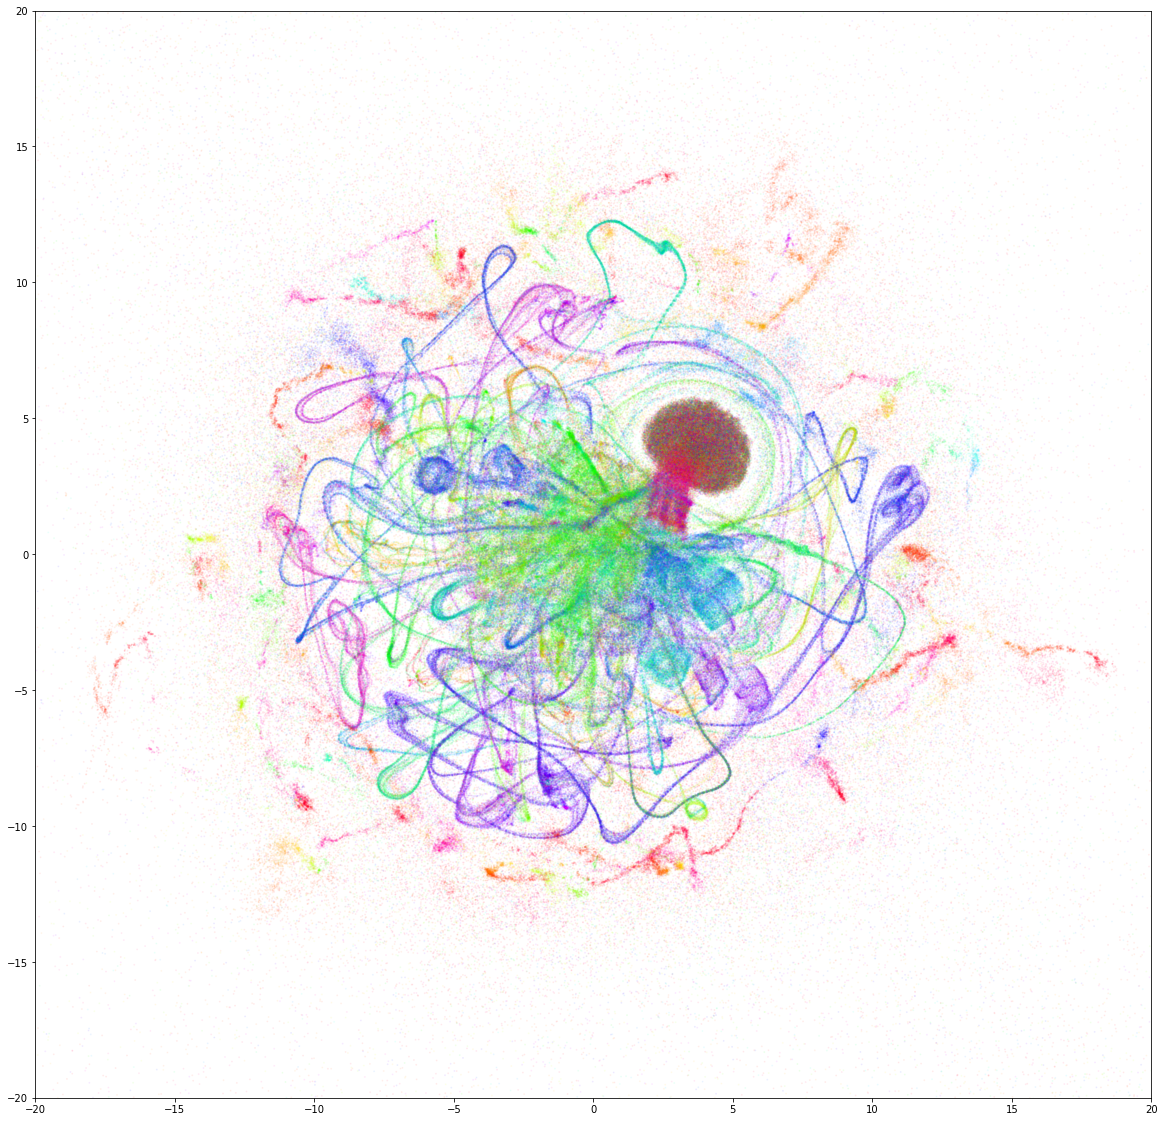

In [44]:
fig, ax = plt.subplots(figsize=(20,20))
curr_idx = 0
for wl in tqdm(window_lengths):
    window_z = z[curr_idx:curr_idx + wl]
    cols = sns.color_palette('hsv', len(window_z))
    ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.05, s = 1, c= cols)
    curr_idx += wl
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

In [48]:
cols = sns.color_palette('hsv', len(window_lengths))
len(cols)

50

(-20, 20)

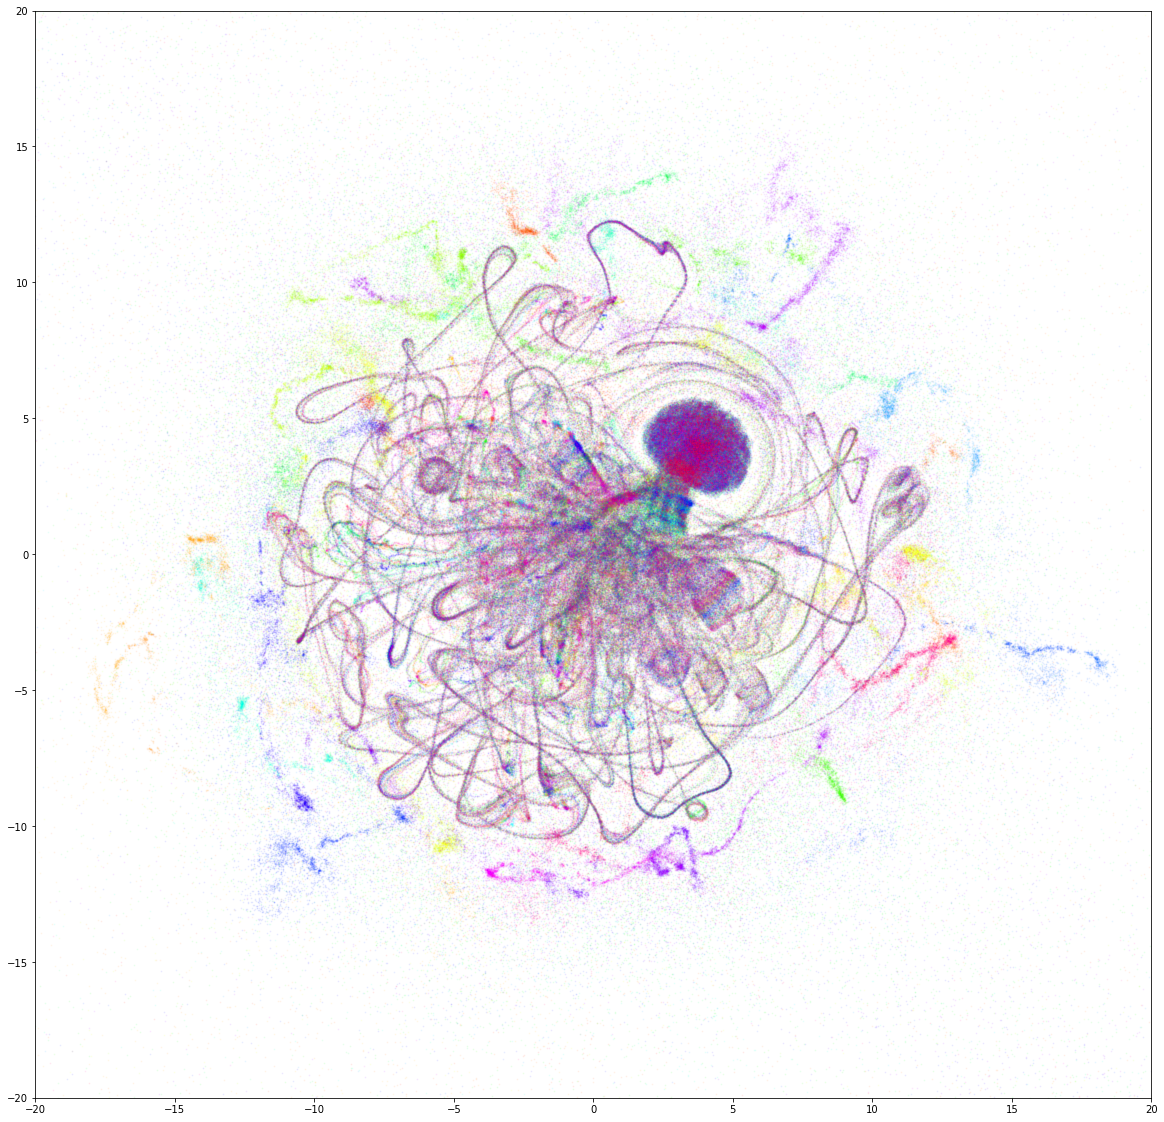

In [49]:
fig, ax = plt.subplots(figsize=(20,20))
curr_idx = 0
for wli, wl in tqdm(enumerate(window_lengths)):
    window_z = z[curr_idx:curr_idx + wl]    
    ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.05, s = 1, color = cols[wli])
    curr_idx += wl
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])

In [52]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [54]:
import copy

In [68]:
z_normed = copy.deepcopy(z)
z_normed[z_normed > 15] = 15
z_normed[z_normed < -15] = -15
z_normed[:,0] = norm(z_normed[:,0])
z_normed[:,1] = norm(z_normed[:,1])

In [70]:
curr_idx = 0
rgb_imgs = []
for wli, wl in tqdm(enumerate(window_lengths)):
    window_z = z_normed[curr_idx:curr_idx + wl]    
    R = norm(window_z[:,0])
    G = norm(window_z[:,1])
    B = np.ones_like(G)/2
    RGB = np.dstack((R,G,B))
    RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
    rgb_img = np.expand_dims(RGB,0)
    rgb_imgs.append(rgb_img)
    curr_idx += wl

In [71]:
np.shape(rgb_imgs[0])

(1, 15459, 3)

In [72]:
img_lens = [np.shape(i)[1] for i in rgb_imgs]
img_lens[:3]

[15459, 15692, 6323]

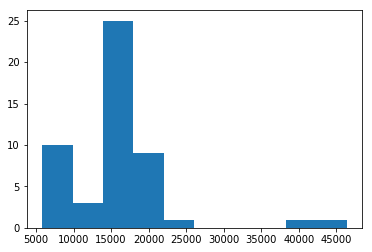

In [73]:
plt.hist(img_lens);

In [76]:
rgb_img = rgb_imgs[1]

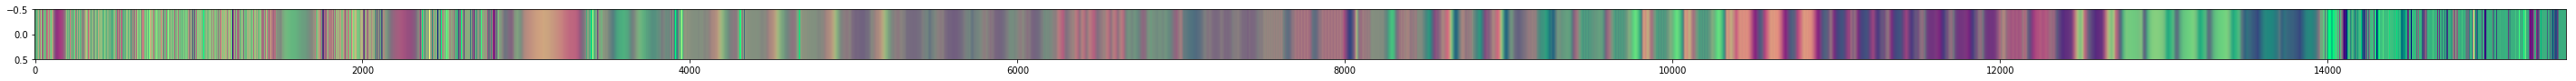

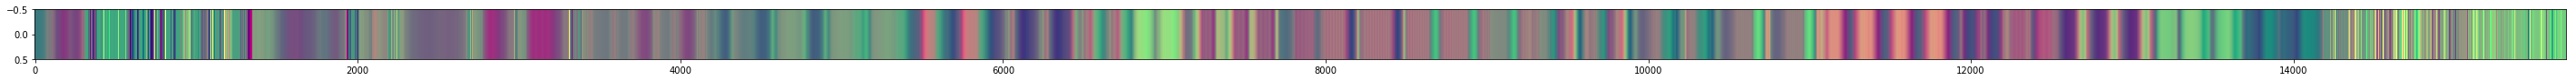

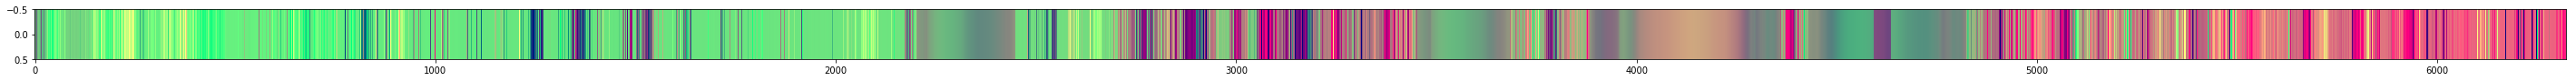

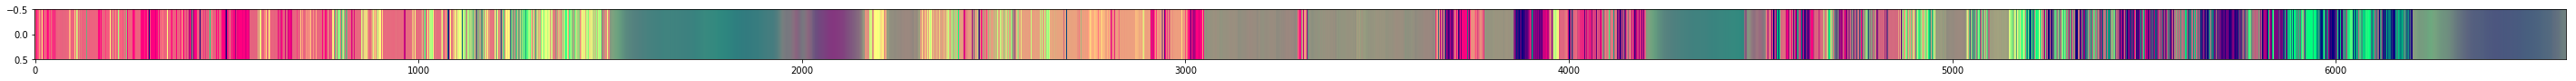

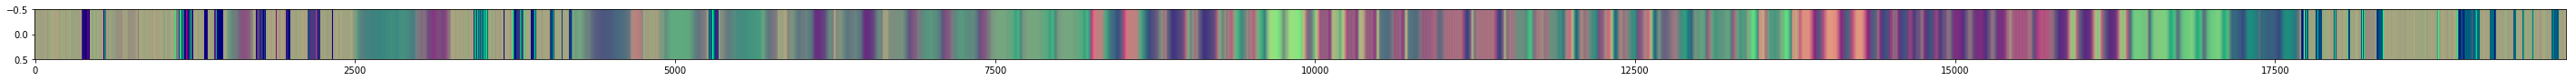

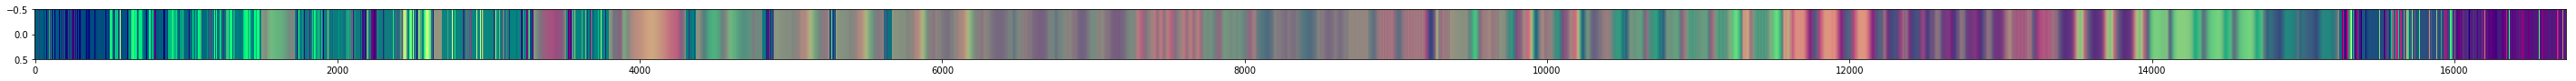

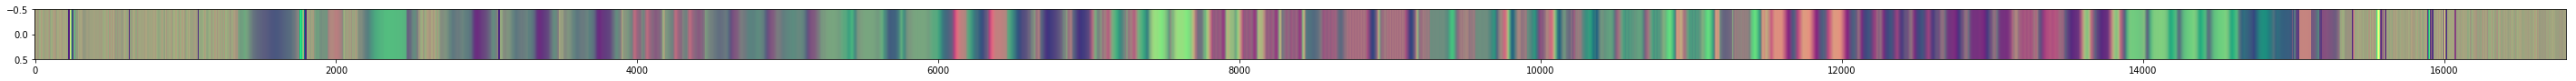

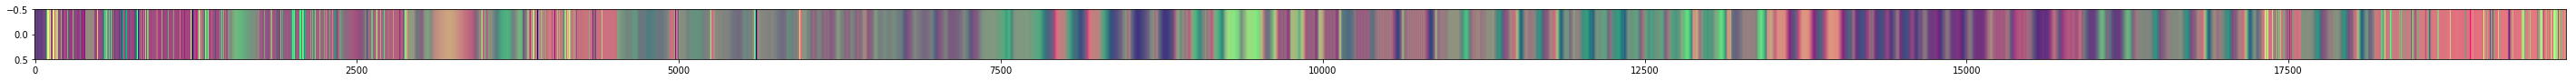

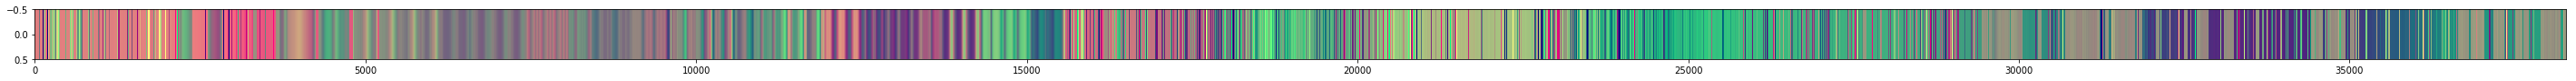

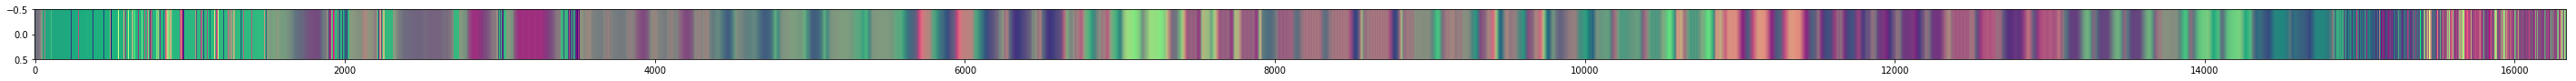

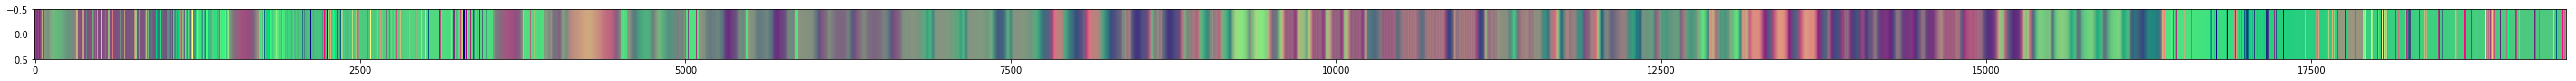

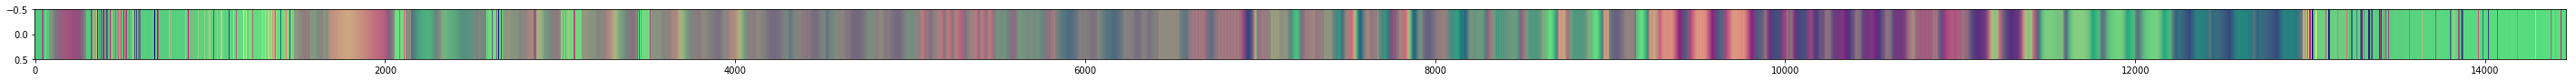

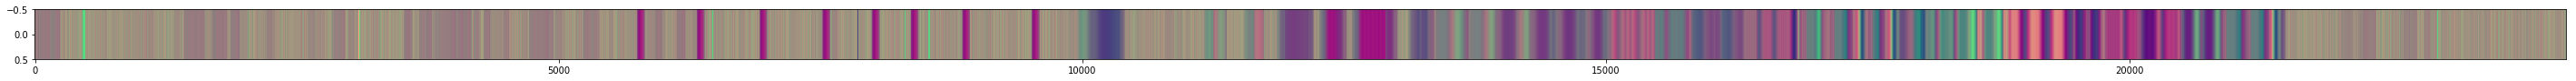

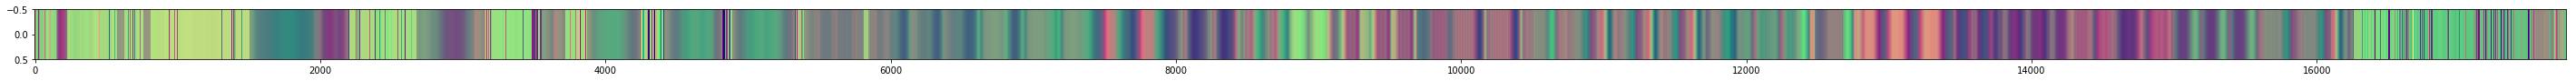

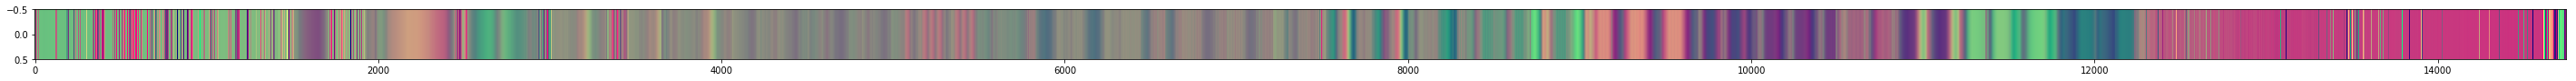

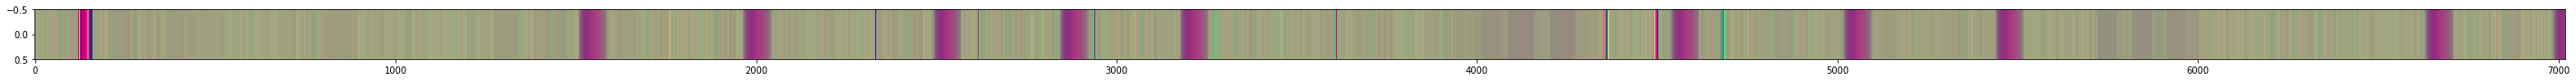

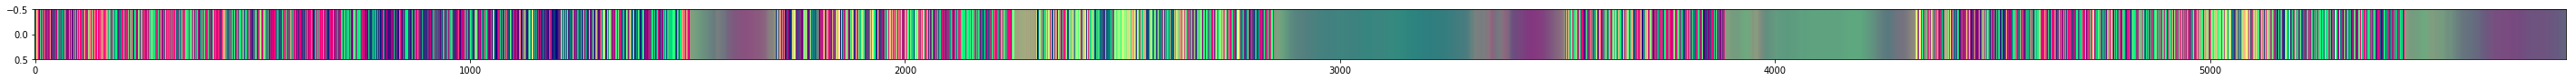

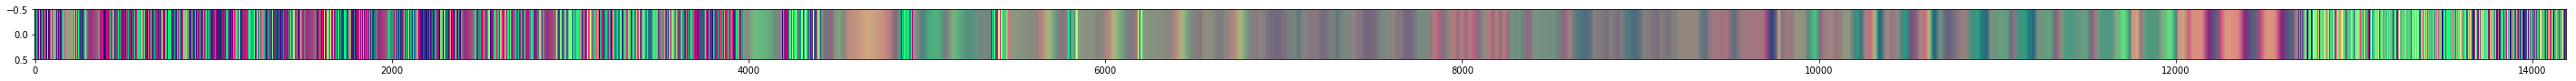

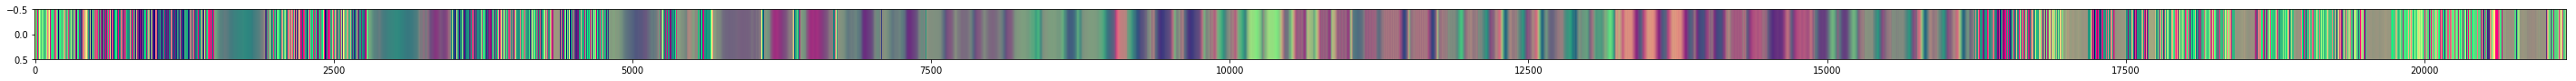

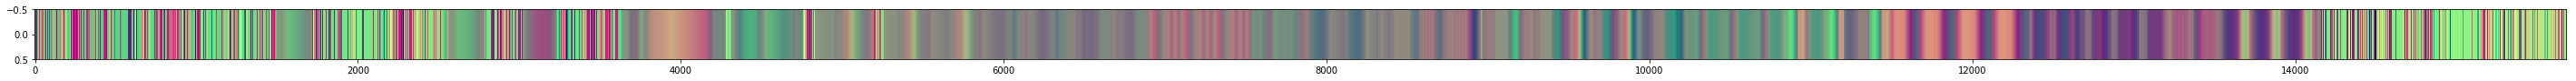

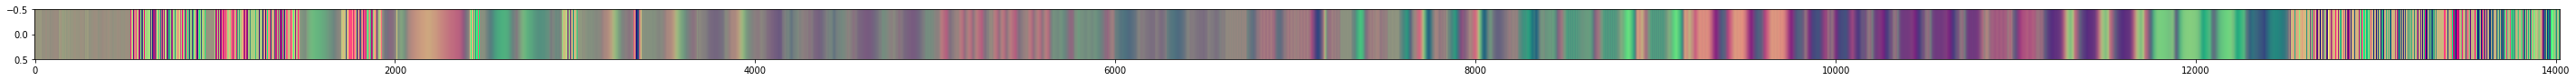

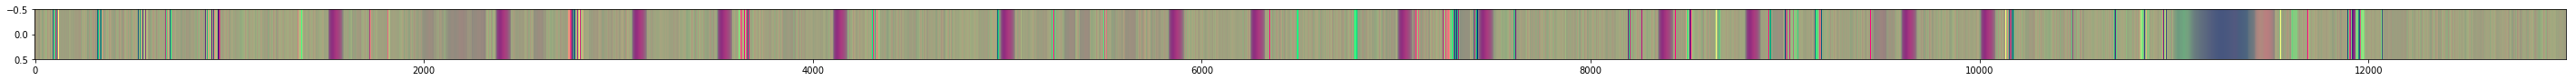

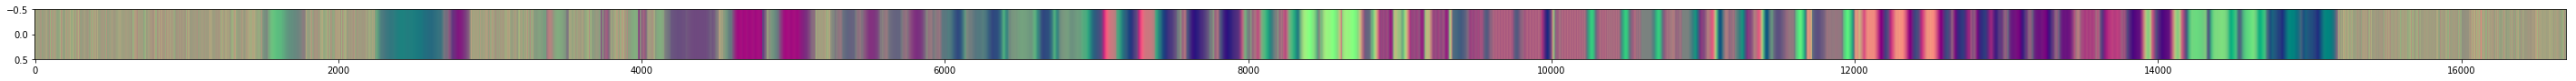

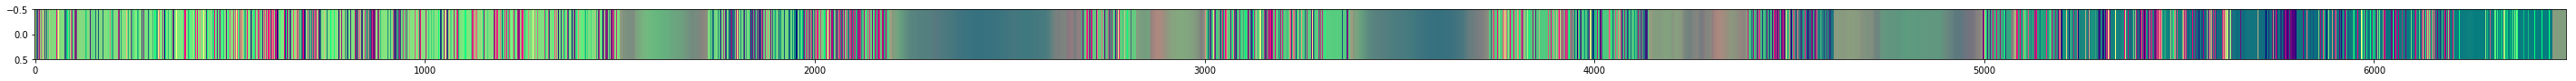

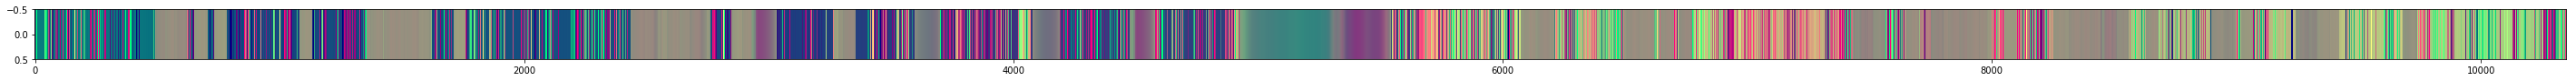

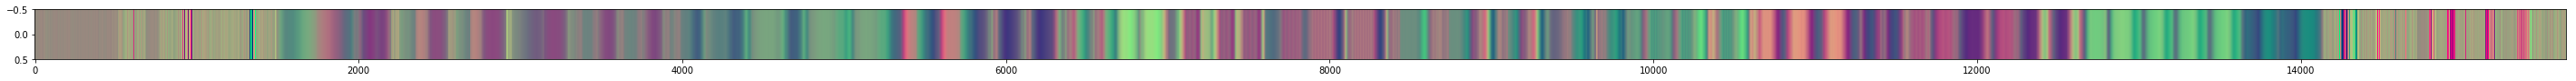

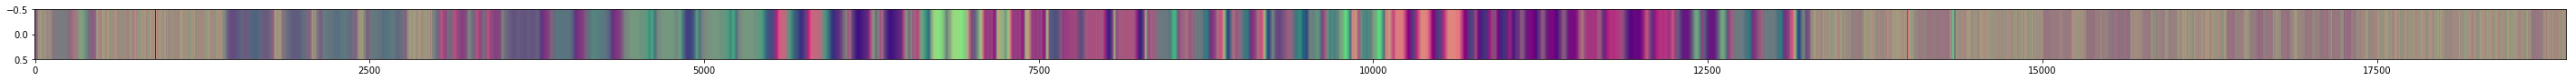

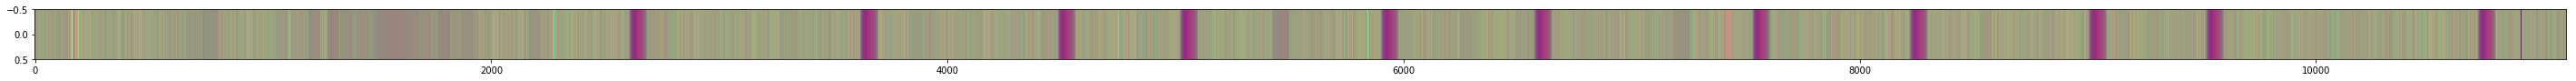

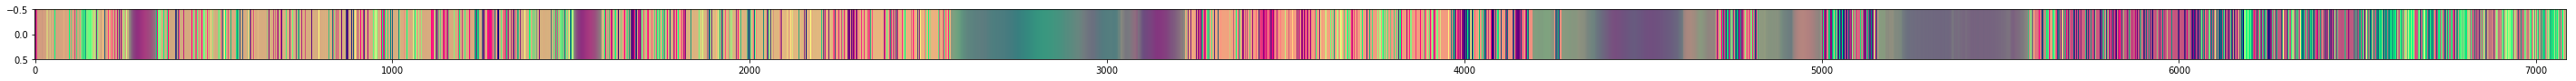

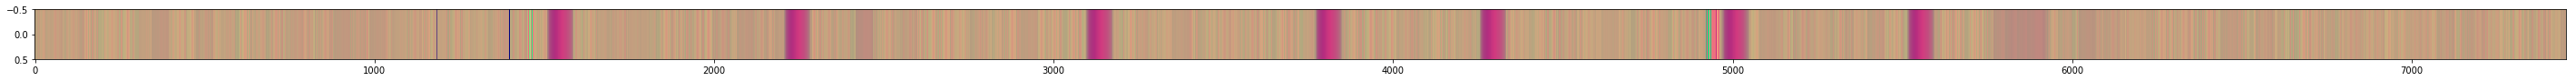

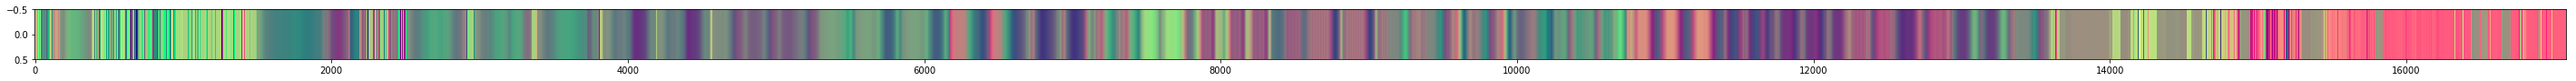

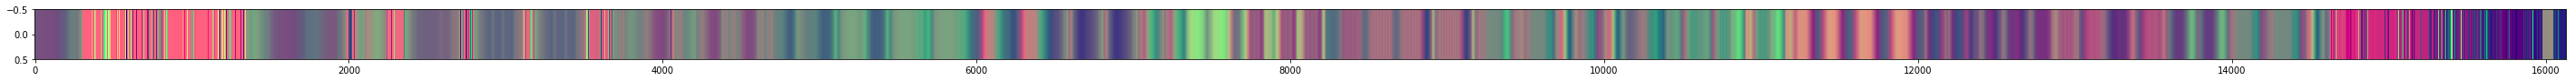

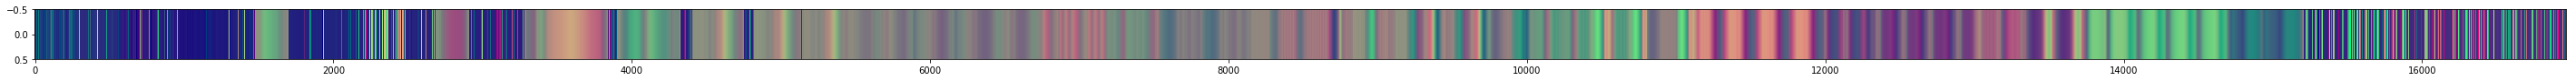

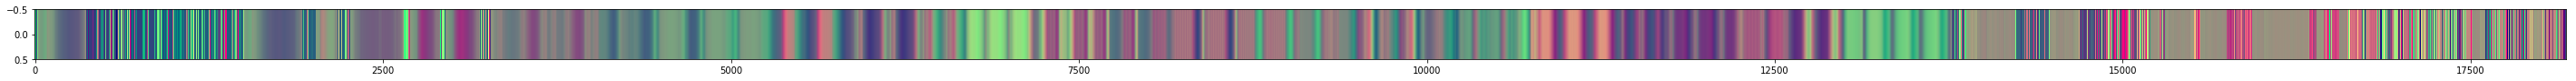

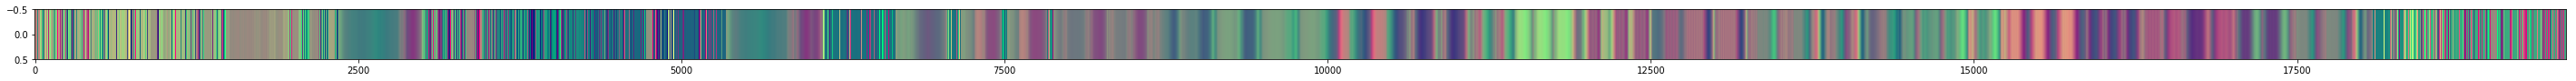

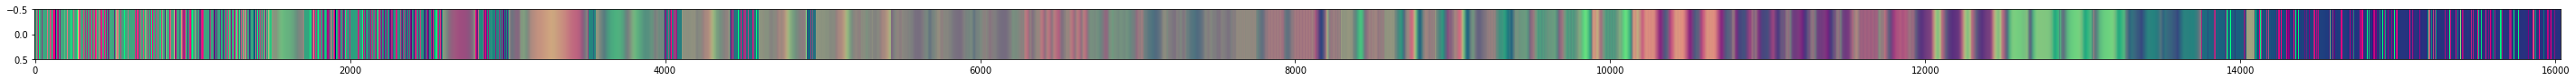

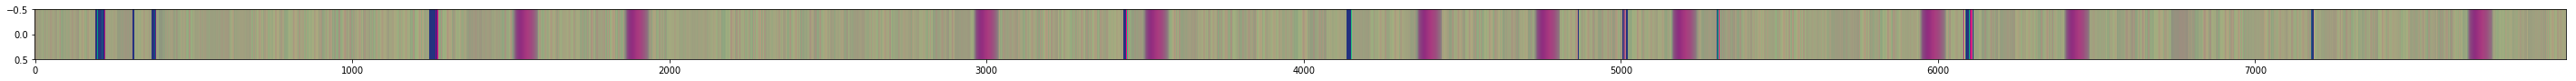

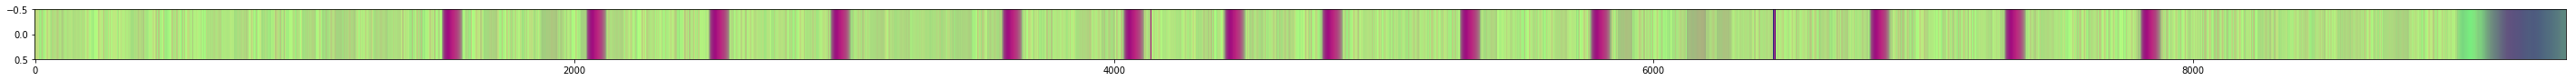

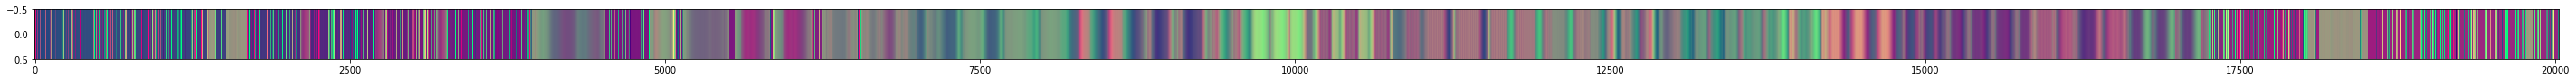

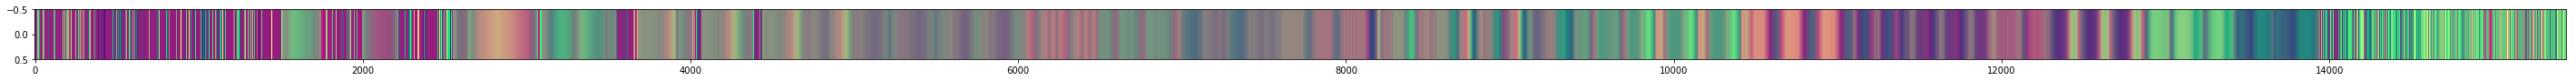

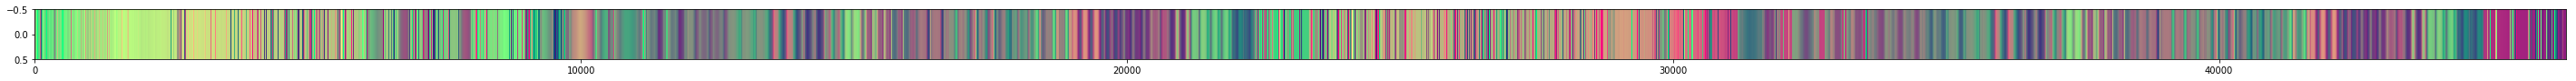

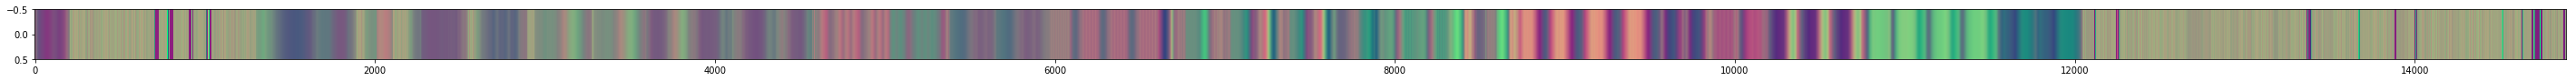

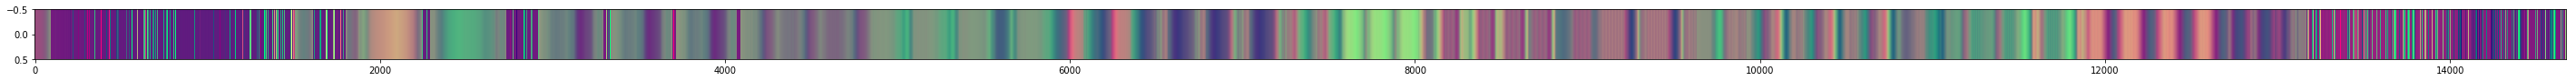

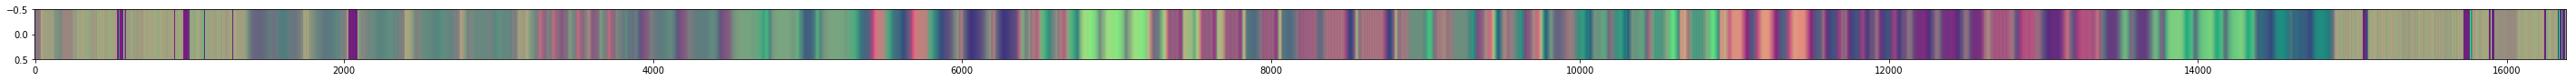

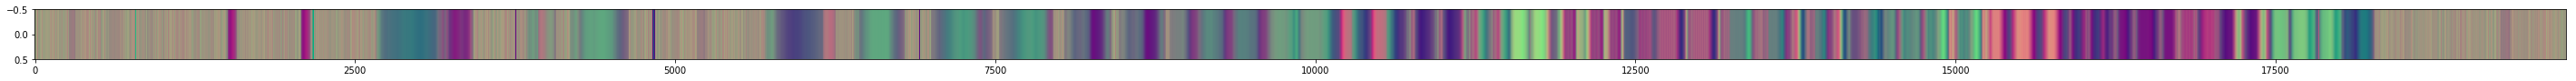

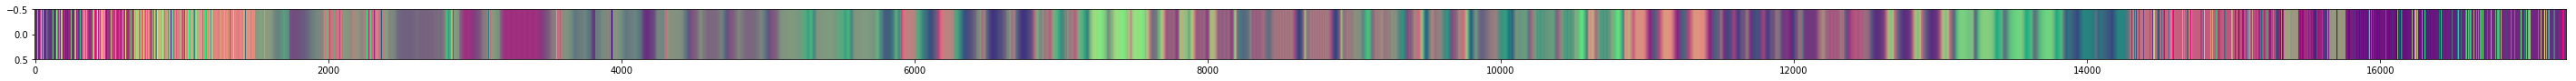

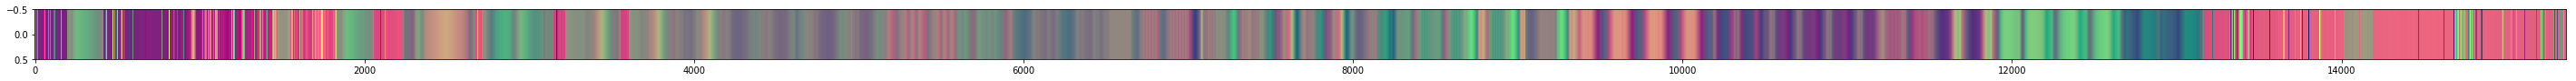

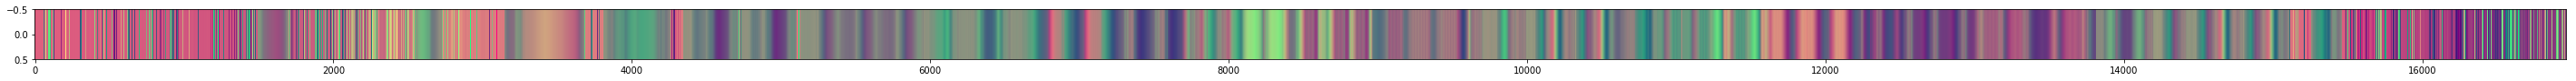

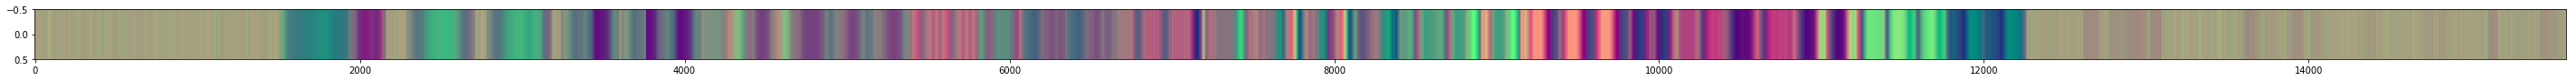

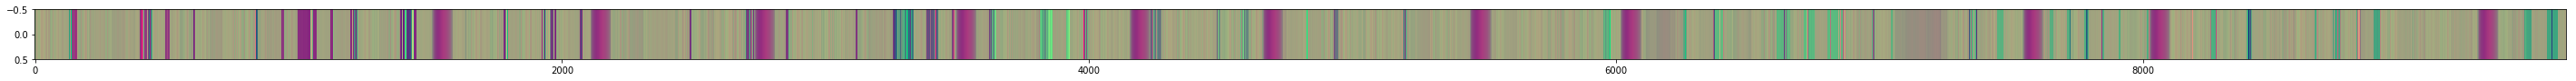

In [78]:
for rgb_img in rgb_imgs:
    fig, ax = plt.subplots(figsize=(50,1))
    ax.imshow(rgb_img, interpolation=None, aspect='auto')
    plt.show()